# Multi-class Image Classification with keras (Intel dataset)

Images of natural scenes around the world are provided in a zip file which contains 3 folders : "seg_train' with 14000 images , "seg_test" with 3000 images and "seg_pred" with 7000 images. Each image is of size 150x150 pixels and each image in seg_train and seg_test is labelled with one of the 6 categories : {buildings, forest, glacier, mountain, sea, street}

The objective is to predict the class to which each image in seg_pred belongs. 

Data Source : https://www.kaggle.com/puneet6060/intel-image-classification/download

## Methodology
**1. Read the images and their corresponding labels  {'buildings':0, 'forest':1, 'glacier':2, 'mountain':3, 'sea':4, 'street':5} into numpy arrays and explore them**<br>
**2. Train a Convolutional Neural Network model in Keras (open-source neural network library running on top of Tensorflow) with seg_train data - 14000 images for training and seg_test data - 3000 images for validation.** <br>
**3. Model evaluation (recall, confusion matrix) and accuracy improvement from 83% to 91%**<br>
**4. Finally, predict the classes of the seg_pred images**

In [111]:
# Import necessary libraries
import cv2 # OpenCV package required
import os
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# GPUs enable faster neural wetwork training with large datasets(compared to CPU) due to higher memory bandwidth and parallelization 
# Anaconda terminal log with GPU enabled (GeForce GTX 1050 Ti)

# I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties:
# pciBusID: 0000:01:00.0 name: GeForce GTX 1050 Ti computeCapability: 6.1
# coreClock: 1.62GHz coreCount: 6 deviceMemorySize: 4.00GiB deviceMemoryBandwidth: 104.43GiB/s
# -----------------------------------------------------------------------------------------------
# I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device 
# (/job:localhost/replica:0/task:0/device:GPU:0 with 2990 MB memory) -> physical GPU 
# (device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1)

# I. Read and Explore Dataset

In [2]:
def read_images(directory):
    """ Function to read images"""
    output_images = []
    output_labels = []
     
    # List the subfolders in the provided directory, each subfolder is a label
    for subfolder in os.listdir(directory):
        # Get label associated with subfolder
        label = get_label(subfolder)
        
        # List the images in current subfolder
        for img in os.listdir(directory+r'/'+subfolder):
            # Read image
            image = cv2.imread(directory+r'/'+subfolder+r'/'+img)
            
            # Resize image ==> All images should have the same width and height: 150 x 150 pixels, no change in number of channels
            image = cv2.resize(image, (150,150))
            output_images.append(image)
            output_labels.append(label)
            
    images = np.array(output_images)
    labels = np.array(output_labels)
    
    # Reshuffle the images to avoid biasing algorithms with the default order
    return shuffle(images, labels,random_state=50)

def get_label(subfolder):
    """"Function to map labels to numerical values"""
    labels = {'buildings':0, 'glacier':1, 'forest':2, 'mountain':3, 'sea':4, 'street':5}
    return labels[subfolder]

In [3]:
# Read train and test images into numpy arrays
train_images, input_train_labels = read_images('seg_train')
test_images, input_test_labels = read_images('seg_test')

# Perform one-hot encoding of labels to obtain an array with as many columns as classes and as many rows as samples
train_labels = to_categorical(input_train_labels)
test_labels = to_categorical(input_test_labels)

# Read pred images into a numpy array
pred_images = []
for img in os.listdir('seg_pred'):
    image = cv2.imread('seg_pred'+r'/'+img)
    image = cv2.resize(image, (150,150))
    pred_images.append(image)
pred_images = np.array(pred_images)

In [4]:
# Shape of Images
print("The shape of train_images : {}, shape of train labels : {}".format(train_images.shape, train_labels.shape))
print("The shape of test_images : {}, shape of test labels : {}".format(test_images.shape, test_labels.shape))
print("The shape of pred_images : ",pred_images.shape)

The shape of train_images : (14034, 150, 150, 3), shape of train labels : (14034, 6)
The shape of test_images : (3000, 150, 150, 3), shape of test labels : (3000, 6)
The shape of pred_images :  (7301, 150, 150, 3)


**All read images are square, with a width and height of 150 pixels and have 3 channels (R, G, B).**

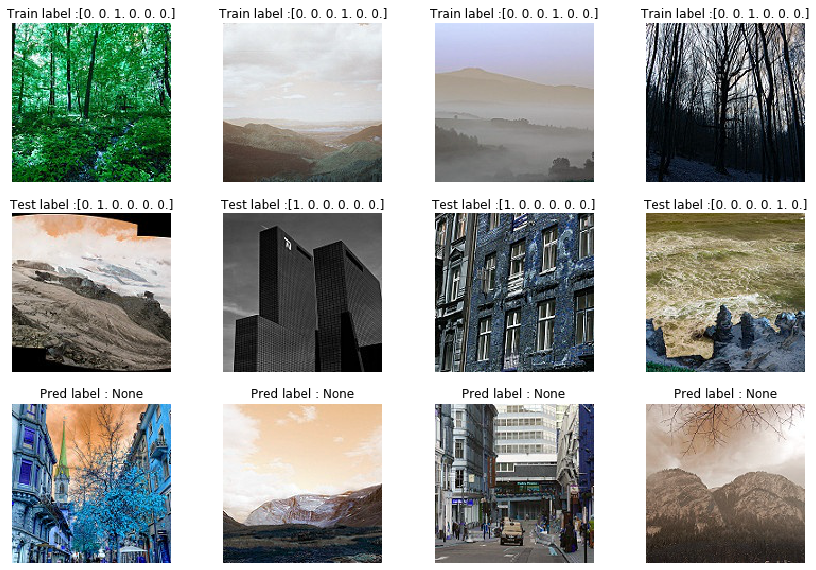

In [5]:
# Display the first 04 images of each data set
fig, ax = plt.subplots(3, 4)

# Leave some space above each subplot
fig.subplots_adjust(top=2, right=2)

for j in range(4):
    #1st row
    ax[0,j].imshow(train_images[j])
    ax[0,j].set_title('Train label :' + str(train_labels[j]))
    ax[0,j].axis('off')
    
    #2nd row
    ax[1,j].imshow(test_images[j])
    ax[1,j].set_title('Test label :'+str(test_labels[j]))
    ax[1,j].axis('off')
    
    #3rd row
    ax[2,j].imshow(pred_images[j])
    ax[2,j].set_title('Pred label : None')
    ax[2,j].axis('off')


**buildings: 0 or [1 0 0 0 0 0],<br>glacier: 1 or [0 1 0 0 0 0],<br>forest: 2 or [0 0 1 0 0 0],<br>mountain: 3 or [0 0 0 1 0 0],<br>sea: 4 or [0 0 0 0 1 0],<br>street: 5 or [0 0 0 0 0 1]**

# II. Train a CNN model
A simple CNN model comprises :
- An input layer (an input image)
- At least one hidden convolutional layer (of class Conv2D()) : In this layer we need to specify the shape of input images,  the number of kernels to be used, the size of these kernels, an activation function. During the training of the CNN, the weights of the kernels are adjusted by the backpropagation algorithm. As compared to a fully connected layer of a simple neural network where each pixel of an image corresponds to a trainable weight/parameter (exple 150x150x3 = 67500), there are much fewer weights in a convolutional layer : the number of kernels (exple 10) * kernel size (exple 3x3) = 90.  
- A flatten layer (of class Flatten()) which converts images convolved by the kernels of the convolutional layer into a 1D array and 
- Finally a fully connected output layer (of class Dense()) which provides the output of the model.

However to extract more complex features from input images, it may be necessary to use additional convolutional layers(inspired by the human visual system) which may have different kernel counts and sizes or even padding types. The difficulty in such training therefore lies in the search for the model architecture which gives optimal results. In this process we may adjust hyperparameters like :
- The number of convolutional layers
- The number and size of kernels per convolutional layer
- The padding type to specify if convolved images of a layer should have the same size as the input image
- The activation function of each layer

Also we need to choose :
- An optimizer or backpropagation algorithm
- A loss function to be minimized by the optmizer

We may use :
- Pooling layers between subsequent convolutional layers to reduce significantly the number of parameters and train the model faster however at a cost

To avoid overfitting our CNN model we can apply regularization techniques like :
- Addition of Dropout layers, to randomly ignore some neurons/kernels during an epoch of training
- Early Stopping, to stop training when the validation error reaches a suitable level
- Batch Normalization, to rescale the outputs of a layer

In [7]:
# 1st Model Architecture
model = Sequential()
model.add(Conv2D(115, kernel_size=3, activation='relu',input_shape=(150,150,3)))
model.add(Conv2D(80, kernel_size=3, activation='relu'))
model.add(MaxPool2D(4))
model.add(Conv2D(100, kernel_size=3, activation='relu'))
model.add(Conv2D(50, kernel_size=3, activation='relu'))
model.add(Conv2D(30, kernel_size=3, activation='relu'))
model.add(MaxPool2D(4))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(6, activation='softmax')) 
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

# Display model architecture
model.summary()

# Fit the model
model.fit(train_images, train_labels, epochs=9, validation_data=(test_images, test_labels))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 115)     3220      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 146, 146, 80)      82880     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 36, 36, 80)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 34, 34, 100)       72100     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 50)        45050     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 30, 30, 30)        13530     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 30)         

We achieve 82.6% validation accuracy in 9 epochs with the above model architecture, obtained after trying several numbers of hidden layers and kernels per layer.<br> Next try : Increase the number of epochs and enable early stopping.

In [8]:
# 2nd Model Architecture - Increase the number of epochs and enable early stopping
model2 = Sequential()
model2.add(Conv2D(115, kernel_size=3, activation='relu',input_shape=(150,150,3)))
model2.add(Conv2D(80, kernel_size=3, activation='relu'))
model2.add(MaxPool2D(4))
model2.add(Conv2D(100, kernel_size=3, activation='relu'))
model2.add(Conv2D(50, kernel_size=3, activation='relu'))
model2.add(Conv2D(30, kernel_size=3, activation='relu'))
model2.add(MaxPool2D(4))
model2.add(Flatten())
model2.add(Dense(100, activation='relu'))
model2.add(Dense(50, activation='relu'))
model2.add(Dropout(0.25))
model2.add(Dense(6, activation='softmax')) 
model2.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

# Display model architecture
model2.summary()

# Fit the model
model2.fit(train_images, train_labels, epochs=50, validation_data=(test_images, test_labels),\
          callbacks=[EarlyStopping(patience=2)])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 148, 148, 115)     3220      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 146, 146, 80)      82880     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 80)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 34, 34, 100)       72100     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 50)        45050     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 30, 30, 30)        13530     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 30)         

# III. Model Evaluation and Interpretation

No improvement observed with model2 compared to the first model. Also with GPU memory of only 4GB, we cannot evaluate more complex model architectures (more trainable parameters). <br><br>**We will consider the first model named "model" with 82.6% accuracy and further assess its performance.**<br>
<br>
We will find out which image classes are well classified by the model and which are poorly classified, using sklearn's classification report and confusion matrix.<br>
**buildings: 0 or [1 0 0 0 0 0]<br>
glacier: 1 or [0 1 0 0 0 0]<br>
forest: 2 or [0 0 1 0 0 0]<br>
mountain: 3 or [0 0 0 1 0 0]<br>
sea: 4 or [0 0 0 0 1 0]<br>
street: 5 or [0 0 0 0 0 1]<br>**

In [10]:
# Predict test labels
predicted_test_labels = model.predict_classes(test_images)
classes = ["building", "glacier", "forest", "mountain", "sea", "street"]

In [32]:
# Classification Report
print(classification_report(input_test_labels, predicted_test_labels, target_names=classes))

              precision    recall  f1-score   support

    building       0.78      0.82      0.80       437
     glacier       0.80      0.75      0.77       553
      forest       0.93      0.97      0.95       474
    mountain       0.82      0.75      0.78       525
         sea       0.78      0.86      0.82       510
      street       0.84      0.83      0.84       501

    accuracy                           0.83      3000
   macro avg       0.83      0.83      0.83      3000
weighted avg       0.83      0.83      0.82      3000



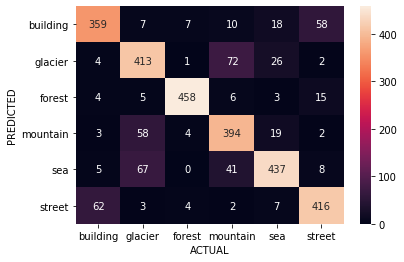

In [29]:
# Confusion Matrix
confusion_mat = confusion_matrix(predicted_test_labels, input_test_labels)

sns.heatmap(confusion_mat, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.ylabel('PREDICTED')
plt.xlabel('ACTUAL')
plt.show()

- 97% (Recall or True Positive Rate) of forest images are accurately classified.<br>
- Only 75% of glacier images are accurately classified with 58 false-negatives classified as "mountain" meanwhile 75% of mountain images are accurately classified with 72 false negatives classified as "glacier". **This shows our model is quite inefficient at distinguishing between glaciers and mountains, probably because images of glaciers and mountains look alike.**<br> 
- Similarly, 62 images of buildings are misclassified as "street" and 58 images of streets wrongly classified as "building". **This suggests streets and buildings have similar features that the neural network fails to distinguish accurately.**<br>

Let's **remove images of streets and glaciers** from the training data and train another model to check if its accuracy improves significantly for the remaining classes.

In [82]:
# 3rd Model - Model to classify four image classes : building, forest, mountain, sea

# Get the images and labels of the four classes - training and testing data
train_images_reduced = train_images[(train_labels[:,0] == 1) | (train_labels[:,2] == 1)\
                                   | (train_labels[:,3] == 1) | (train_labels[:,4] == 1)]
test_images_reduced = test_images[(test_labels[:,0] == 1) | (test_labels[:,2] == 1)\
                                   | (test_labels[:,3] == 1) | (test_labels[:,4] == 1)]
train_labels_reduced = train_labels[(train_labels[:,0] == 1) | (train_labels[:,2] == 1)\
                                   | (train_labels[:,3] == 1) | (train_labels[:,4] == 1)][:,[0,2,3,4]]
test_labels_reduced = test_labels[(test_labels[:,0] == 1) | (test_labels[:,2] == 1)\
                                   | (test_labels[:,3] == 1) | (test_labels[:,4] == 1)][:,[0,2,3,4]]

model_reduced = Sequential()
model_reduced.add(Conv2D(115, kernel_size=3, activation='relu',input_shape=(150,150,3)))
model_reduced.add(Conv2D(80, kernel_size=3, activation='relu'))
model_reduced.add(MaxPool2D(4))
model_reduced.add(Conv2D(100, kernel_size=3, activation='relu'))
model_reduced.add(Conv2D(50, kernel_size=3, activation='relu'))
model_reduced.add(Conv2D(30, kernel_size=3, activation='relu'))
model_reduced.add(MaxPool2D(4))
model_reduced.add(Flatten())
model_reduced.add(Dense(100, activation='relu'))
model_reduced.add(Dense(50, activation='relu'))
model_reduced.add(Dropout(0.25))
model_reduced.add(Dense(4, activation='softmax')) 
model_reduced.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

# Display model architecture
model_reduced.summary()

# Fit the model
model_reduced.fit(train_images_reduced, train_labels_reduced, epochs=9,\
                  validation_data=(test_images_reduced, test_labels_reduced))

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 148, 148, 115)     3220      
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 146, 146, 80)      82880     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 36, 36, 80)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 34, 34, 100)       72100     
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 32, 32, 50)        45050     
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 30, 30, 30)        13530     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 7, 7, 30)         

In [107]:
# Predict test labels for four image classes
predicted_test_labels_reduced = model_reduced.predict_classes(test_images_reduced)
classes_reduced = ["building", "forest", "mountain", "sea"]

# Get the labels 0,2,3,4 of the four classes from the test dataset
input_test_labels_reduced = input_test_labels[(input_test_labels != 1) & (input_test_labels != 5)]

# Change the labels 2,3,4 to 1,2,3 to match the labels of the model's prediction
input_test_labels_reduced[input_test_labels_reduced == 2] = 1
input_test_labels_reduced[input_test_labels_reduced == 3] = 2
input_test_labels_reduced[input_test_labels_reduced == 4] = 3

# Classification Report
print(classification_report(input_test_labels_reduced, predicted_test_labels_reduced, target_names=classes_reduced))

              precision    recall  f1-score   support

    building       0.92      0.93      0.93       437
      forest       0.98      0.94      0.96       474
    mountain       0.92      0.84      0.88       525
         sea       0.82      0.92      0.87       510

    accuracy                           0.91      1946
   macro avg       0.91      0.91      0.91      1946
weighted avg       0.91      0.91      0.91      1946



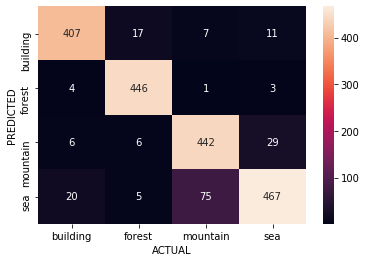

In [108]:
# Confusion Matrix
confusion_mat_reduced = confusion_matrix(predicted_test_labels_reduced, input_test_labels_reduced)

sns.heatmap(confusion_mat_reduced, annot=True, fmt='d', xticklabels=classes_reduced, yticklabels=classes_reduced)
plt.ylabel('PREDICTED')
plt.xlabel('ACTUAL')
plt.show()

- The model's overall accuracy on the test dataset has improved from 83% to 90% after the removal of two image classes from the training and testing datasets. **This confirms there are similar features in several glacier and mountain images(as well as street and building images or mountain and sea images) which the neural network fails to distinguish.** Should we proceed to use the first model(with 6 classes) or not ? Ultimately, the answer depends on the use case and the required classification accuracy level.

# IV. Prediction of Image Classes

In [110]:
model.predict_classes(pred_images)

array([5, 4, 5, ..., 3, 2, 5], dtype=int64)

Useful links :<br>
How to enable keras neural network training on CUDA-compatible NVIDIA GPU<br>
https://towardsdatascience.com/python-environment-setup-for-deep-learning-on-windows-10-c373786e36d1<br>
https://www.youtube.com/watch?v=KZFn0dvPZUQ